<a href="https://www.kaggle.com/code/lonnieqin/house-price-prediction-with-tf-catboost-top-1?scriptVersionId=115156228" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## House Price Prediction With TF & CatBoost (Top 1%)

## Table of Contents
- Import Packages
- Common Funtions
- Import Dataset
- EDA & Data Preprocessing
    - Missing Value Imputation
    - Convert Categorical Features to Numerical Features
    - Basic Statistic Info
    - Find Related Features
    - Normalization
- Model Development & Evaluation
    - Using DNN
    - Using CatBoost
        - Hyperparameter Tuning
        - Model Training with K-Fold algorithm
        - Model Training with all data
- Conclusion

## Import Packages

In [1]:
import numpy as np
import pandas as pd 
import os
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

## Common Functions

In [2]:
def submit(model, ids, test_features, file_name):
    result = np.square(model.predict(test_features))
    submission = pd.DataFrame({"Id": list(ids), "SalePrice": result.reshape(-1)})
    submission.to_csv(file_name, index=False)

## Import dataset

In [3]:
train = pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv")
test = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv")

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## EDA & Data Preprocessing

### Missing Value Imputation

In [6]:
should_impute = True
if should_impute: 
    for data in [train, test]:
        null_features = data.dtypes[data.isnull().sum() > 0]
        for feature, feature_type in zip(list(null_features.index), null_features):
            if feature_type == "float64":
                data[feature].replace(np.NAN, data[feature].mean(), inplace=True)
            else:
                data[feature].replace(np.NAN, "Unknown", inplace=True)

### Convert Categorical Features to Numerical Features

In [7]:
train_test = pd.concat([train, test])
train_test = pd.get_dummies(train_test)
train_test.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_Unknown,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,0,1,0,0,0,0,1,0


Now calculate its mean and std value for futher normalization, please be noted that SalePrice wouldn't be normalized. In order to see statistic infos, I will normalize them after EDA.

In [8]:
mean_value = train_test.mean()
std_value = train_test.std()
_ = mean_value.pop("SalePrice")
_ = std_value.pop("SalePrice")

In [9]:
train_features = train_test.iloc[: len(train)]
test_features = train_test.iloc[len(train):]
_ = test_features.pop("SalePrice")

In [10]:
train_features.shape

(1460, 313)

### Basic Statistic Info

In [11]:
train_features.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_Unknown,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.0,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,0.083562,0.002055,0.0,0.867808,0.069178,0.002740,0.008219,0.013699,0.820548,0.085616
std,421.610009,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,20.645407,180.569112,456.098091,...,0.276824,0.045299,0.0,0.338815,0.253844,0.052289,0.090317,0.116277,0.383862,0.279893
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,730.500000,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
corr = train_features.corr()
corr

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_Unknown,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,1.000000,0.011156,-0.009601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050199,-0.005024,...,-0.018998,0.038920,NaN,0.026133,0.007009,-0.034852,-0.009018,0.004865,0.015881,-0.020738
MSSubClass,0.011156,1.000000,-0.357056,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022895,-0.069836,...,-0.045156,-0.014555,NaN,0.026359,0.005003,0.016241,0.030002,0.000983,0.024359,-0.051068
LotFrontage,-0.009601,-0.357056,1.000000,0.306795,0.234196,-0.052820,0.117598,0.082746,0.179283,0.215828,...,0.126580,-0.023461,NaN,-0.089928,-0.021846,-0.037020,-0.018090,0.015818,-0.072074,0.124842
LotArea,-0.033226,-0.139781,0.306795,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103960,0.214103,...,0.020039,-0.005722,NaN,-0.002292,-0.029126,-0.013208,0.008966,-0.010781,0.005711,0.022635
OverallQual,-0.028365,0.032628,0.234196,0.105806,1.000000,-0.091932,0.572323,0.550684,0.410238,0.239666,...,0.327412,-0.057962,NaN,-0.225013,-0.103535,-0.041677,-0.044950,-0.025515,-0.143282,0.323295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SaleCondition_AdjLand,-0.034852,0.016241,-0.037020,-0.013208,-0.041677,-0.038888,-0.045601,-0.040294,-0.011959,-0.014874,...,-0.015827,-0.002378,NaN,0.020457,-0.014289,1.000000,-0.004772,-0.006177,-0.112080,-0.016038
SaleCondition_Alloca,-0.009018,0.030002,-0.018090,0.008966,-0.044950,-0.033444,-0.010104,-0.020727,-0.009689,0.021369,...,-0.027489,-0.004131,NaN,0.035530,-0.024817,-0.004772,1.000000,-0.010729,-0.194663,-0.027856
SaleCondition_Family,0.004865,0.000983,0.015818,-0.010781,-0.025515,-0.023873,-0.035785,-0.048056,-0.009914,0.000765,...,-0.035587,-0.005348,NaN,0.028599,-0.032128,-0.006177,-0.010729,1.000000,-0.252006,-0.036062
SaleCondition_Normal,0.015881,0.024359,-0.072074,0.005711,-0.143282,0.161642,-0.158427,-0.120577,-0.084241,-0.019560,...,-0.645698,-0.097031,NaN,0.634322,-0.582947,-0.112080,-0.194663,-0.252006,1.000000,-0.654323


### Find Related Features

As we can see Sale Price is related to a lot of factors. I will filter them with a thresold, say 0.05. Then there is 193 features. Actually this thresold is a hyper parameter to filter useful features.

In [13]:
sale_price_corr = corr["SalePrice"]
sale_price_corr = sale_price_corr.sort_values(key = lambda val: abs(val), ascending=False)
sale_price_corr.head(30)

SalePrice               1.000000
OverallQual             0.790982
GrLivArea               0.708624
GarageCars              0.640409
GarageArea              0.623431
TotalBsmtSF             0.613581
1stFlrSF                0.605852
ExterQual_TA           -0.589044
FullBath                0.560664
BsmtQual_Ex             0.553105
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
KitchenQual_TA         -0.519298
YearRemodAdd            0.507101
KitchenQual_Ex          0.504094
Foundation_PConc        0.497734
MasVnrArea              0.475241
FireplaceQu_Unknown    -0.471908
GarageYrBlt             0.470177
Fireplaces              0.466929
ExterQual_Gd            0.452466
BsmtQual_TA            -0.452394
ExterQual_Ex            0.451164
BsmtFinType1_GLQ        0.434597
HeatingQC_Ex            0.434543
GarageFinish_Fin        0.419678
GarageFinish_Unf       -0.410608
Neighborhood_NridgHt    0.402149
BsmtFinSF1              0.386420
MasVnrType_None        -0.374468
Name: Sale

In [14]:
threadsold = 0.01

In [15]:
related_columns = list(sale_price_corr[sale_price_corr.abs() > threadsold].index)
related_columns.remove("SalePrice")
print(related_columns, len(related_columns))

['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'ExterQual_TA', 'FullBath', 'BsmtQual_Ex', 'TotRmsAbvGrd', 'YearBuilt', 'KitchenQual_TA', 'YearRemodAdd', 'KitchenQual_Ex', 'Foundation_PConc', 'MasVnrArea', 'FireplaceQu_Unknown', 'GarageYrBlt', 'Fireplaces', 'ExterQual_Gd', 'BsmtQual_TA', 'ExterQual_Ex', 'BsmtFinType1_GLQ', 'HeatingQC_Ex', 'GarageFinish_Fin', 'GarageFinish_Unf', 'Neighborhood_NridgHt', 'BsmtFinSF1', 'MasVnrType_None', 'SaleType_New', 'GarageType_Detchd', 'SaleCondition_Partial', 'Foundation_CBlock', 'FireplaceQu_Gd', 'GarageType_Attchd', 'LotFrontage', 'MasVnrType_Stone', 'Neighborhood_NoRidge', 'WoodDeckSF', 'KitchenQual_Gd', '2ndFlrSF', 'OpenPorchSF', 'HeatingQC_TA', 'BsmtExposure_Gd', 'Exterior2nd_VinylSd', 'Exterior1st_VinylSd', 'MSZoning_RM', 'HalfBath', 'GarageCond_TA', 'LotShape_Reg', 'LotArea', 'BsmtExposure_No', 'FireplaceQu_Ex', 'CentralAir_Y', 'CentralAir_N', 'GarageQual_TA', 'MSZoning_RL', 'HouseStyle_2Story', 'SaleType_WD

### Feature Scaling

In [16]:
train_targets = sklearn.utils.shuffle(train_features)

In [17]:
related_train_features = train_features[related_columns]
related_test_features = test_features[related_columns]

In [18]:
scale_strategy = ["standard", "sqrt", "log"][0]
for column in related_columns:
    # Don't normlize Categorical Feature
    if not "_" in column:
        if scale_strategy == "standard":
            related_train_features.loc[:, column] = (related_train_features.loc[:, column] - mean_value[column]) / std_value[column]
            related_test_features.loc[:, column] = (related_test_features.loc[:, column] - mean_value[column]) / std_value[column]
        elif scale_strategy == "sqrt":
            related_train_features.loc[:, column] = np.sqrt(related_train_features.loc[:, column] + 10e-8)
            related_test_features.loc[:, column] = np.sqrt(related_test_features.loc[:, column] + 10e-8)
        else:
            related_train_features.loc[:, column] = np.log(related_train_features.loc[:, column].abs() + 1)
            related_test_features.loc[:, column] = np.log(related_test_features.loc[:, column].abs() + 1)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [19]:
related_train_features.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,ExterQual_TA,FullBath,BsmtQual_Ex,TotRmsAbvGrd,...,Neighborhood_SawyerW,Condition2_RRAn,RoofMatl_Roll,SaleType_ConLI,Utilities_AllPub,Utilities_NoSeWa,Foundation_Stone,PoolQC_Gd,ExterCond_Ex,BsmtFinSF2
0,0.646073,0.413476,0.306476,0.348840,-0.444247,-0.773728,0,0.781232,0,0.986680,...,0,0,0,0,1,0,0,0,0,-0.293086
1,-0.063174,-0.471810,0.306476,-0.059782,0.477034,0.261030,1,0.781232,0,-0.287709,...,0,0,0,0,1,0,0,0,0,-0.293086
2,0.646073,0.563659,0.306476,0.627446,-0.299021,-0.610614,0,0.781232,0,-0.287709,...,0,0,0,0,1,0,0,0,0,-0.293086
3,0.646073,0.427309,1.619684,0.785323,-0.671164,-0.506118,1,-1.027187,0,0.349486,...,0,0,0,0,1,0,0,0,0,-0.293086
4,1.355319,1.377806,1.619684,1.686149,0.211541,-0.037164,0,0.781232,0,1.623875,...,0,0,0,0,1,0,0,0,0,-0.293086


In [20]:
train_targets = train_features["SalePrice"]
train_targets.head()

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

<AxesSubplot:>

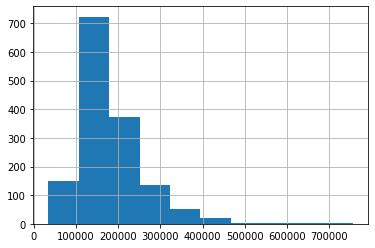

In [21]:
train_targets.hist()

### Log Scaling on House Price

In [22]:
train_targets = np.sqrt(train_targets)

## Model Development & Evaluation
### Using DNN
Training DNN Model Can be time consuming and it's hard to find a good hyperparameter that outperforms other Models. But I like TensorFlow, so I would like to add this solution. besides it's still useful to keep this code for futher study. So I will add a Toggle to control wheter to train with DNN.

In [23]:
from sklearn.model_selection import KFold

should_train_with_dnn = False

def train_with_dnn(related_train_features, train_targets):
    best_model = None
    best_score = 10e8
    index = 1
    should_train_with_dnn = False
    for train_indices, valid_indices in KFold(n_splits=5).split(related_train_features):
        X_train = related_train_features.iloc[train_indices]
        X_val = related_train_features.iloc[valid_indices]
        y_train = train_targets.iloc[train_indices]
        y_val = train_targets.iloc[valid_indices]
        model = tf.keras.Sequential([
            tf.keras.layers.Input((X_train.shape[-1])),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1)
        ])
        model.compile(loss="mse", optimizer="adam", metrics=["mae"])
        early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
        model_checkpoint_path = "model%d.h5"%(index)
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_path, save_best_only=True)
        history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stop, model_checkpoint], verbose=0)
        for item in ["loss", "mae"]:
            pd.DataFrame(history.history, columns=[item, "val_" + item]).plot()
            plt.title("%s in Fold %d"%(item.capitalize(), index))
            plt.show()
        model.load_weights(model_checkpoint_path)
        _, mae = model.evaluate(X_val, y_val)
        submit(model, test["Id"], related_test_features, "submission_dnn_fold_%d.csv"%(index))
        if mae < best_score:
            best_score = mae
            best_model = model
        index += 1
    return best_model
if should_train_with_dnn:
    best_model = train_with_dnn(related_train_features, train_targets)
    

## Using CatBoost

First I will find best parameters, then I will use K-Fold alogorithm to train the Model, finally I will train the Model with all data to see what difference do they have.

### Hyperparameter Tuning

In [24]:
import catboost
import time
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
begin = time.time()
X_train, X_val, y_train, y_val = train_test_split(related_train_features, train_targets)
parameters = {
    "depth": [6, 7, 8, 9, 10],
    "learning_rate": [0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.18, 0.19, 0.2, 0.21, 0.22],
    "iterations": [500, 1000], 
}
def train_catboost(hyperparameters, X_train, X_val, y_train, y_val):
    keys = hyperparameters.keys()
    best_index = {key:0 for key in keys}
    best_cat = None
    best_score = 10e8
    for (index, key) in enumerate(keys):
        print("Find best %s" %(key))
        items = hyperparameters[key]
        best_parameter = None
        temp_best = 10e8
        for (key_index, item) in enumerate(items):
            iterations = hyperparameters["iterations"][best_index["iterations"]] if key != "iterations" else item
            learning_rate = hyperparameters["learning_rate"][best_index["learning_rate"]] if key != "learning_rate" else item
            depth = hyperparameters["depth"][best_index["depth"]] if key != "depth" else item
            print("Train with iterations: %d learning_rate: %.2f depth:%d"%(iterations, learning_rate, depth))
            cat = catboost.CatBoostRegressor(
                iterations = iterations, 
                learning_rate = learning_rate,
                depth = depth
            )
            if best_cat == None:
                best_cat = cat
            cat.fit(X_train, y_train, verbose=False)
            y_pred = cat.predict(X_val)
            score = mean_absolute_error(np.square(y_val), np.square(y_pred))
            print("MAE: %.2f"%(score))
            if score < temp_best:
                temp_best = score
                best_index[key] = key_index
                best_parameter = item
            if score < best_score:
                best_score = score
                best_cat = cat
        print("Best %s: "%(key), best_parameter)
    best_parameters = {
        "iterations": hyperparameters["iterations"][best_index["iterations"]],
        "learning_rate": hyperparameters["learning_rate"][best_index["learning_rate"]],
        "depth": hyperparameters["depth"][best_index["depth"]]
    }
    return best_cat, best_score, best_parameters
best_cat, best_score, best_parameters = train_catboost(parameters, X_train, X_val, y_train, y_val)
print("Best CatBoost Model: ", best_cat)
print("Best MAE: ", best_score)
elapsed = time.time() - begin 
print("Elapsed time: ", elapsed)
submit(best_cat, test["Id"], related_test_features, "submission_cat.csv")

Find best depth
Train with iterations: 500 learning_rate: 0.07 depth:6
MAE: 14108.34
Train with iterations: 500 learning_rate: 0.07 depth:7
MAE: 14523.25
Train with iterations: 500 learning_rate: 0.07 depth:8
MAE: 14529.73
Train with iterations: 500 learning_rate: 0.07 depth:9
MAE: 14847.52
Train with iterations: 500 learning_rate: 0.07 depth:10
MAE: 15532.46
Best depth:  6
Find best learning_rate
Train with iterations: 500 learning_rate: 0.07 depth:6
MAE: 14108.34
Train with iterations: 500 learning_rate: 0.08 depth:6
MAE: 14369.08
Train with iterations: 500 learning_rate: 0.09 depth:6
MAE: 14825.29
Train with iterations: 500 learning_rate: 0.10 depth:6
MAE: 14552.04
Train with iterations: 500 learning_rate: 0.11 depth:6
MAE: 14814.84
Train with iterations: 500 learning_rate: 0.12 depth:6
MAE: 14102.59
Train with iterations: 500 learning_rate: 0.18 depth:6
MAE: 14491.50
Train with iterations: 500 learning_rate: 0.19 depth:6
MAE: 14615.08
Train with iterations: 500 learning_rate: 0.20 

### Model Training with K-Fold algorithm
I will use best parameters to train the Model with K-Fold algorithm. Results can be different and the validation MAE is different from actual result, so I will keep tract of each test result.

In [25]:
models = []
for fold, (train_indices, valid_indices) in enumerate(KFold(n_splits=5, shuffle=True).split(related_train_features)):
    print("Training with Fold %d" % (fold + 1))
    X_train = related_train_features.iloc[train_indices]
    X_val = related_train_features.iloc[valid_indices]
    y_train = train_targets.iloc[train_indices]
    y_val = train_targets.iloc[valid_indices]
    cat = catboost.CatBoostRegressor(
        iterations = 10000, 
        learning_rate = best_parameters["learning_rate"],
        depth = best_parameters["depth"],
        early_stopping_rounds=500
    )
    cat.fit(X_train, y_train, verbose=500)
    y_pred = cat.predict(X_val)
    score = mean_absolute_error(np.square(y_val), np.square(y_pred))
    print("MAE: %.2f"%(score))
    submit(cat, test["Id"], related_test_features, "submission_cat_fold_%d.csv"%(fold))
    models.append(cat)
    fold += 1

Training with Fold 1
0:	learn: 80.1672626	total: 4.82ms	remaining: 48.2s
500:	learn: 4.4140175	total: 2.23s	remaining: 42.2s
1000:	learn: 1.3102744	total: 4.51s	remaining: 40.6s
1500:	learn: 0.4560383	total: 6.73s	remaining: 38.1s
2000:	learn: 0.1567371	total: 8.97s	remaining: 35.9s
2500:	learn: 0.0603222	total: 11.2s	remaining: 33.6s
3000:	learn: 0.0239101	total: 13.4s	remaining: 31.4s
3500:	learn: 0.0097144	total: 15.8s	remaining: 29.3s
4000:	learn: 0.0040937	total: 18.1s	remaining: 27.1s
4500:	learn: 0.0017478	total: 20.4s	remaining: 24.9s
5000:	learn: 0.0007019	total: 22.7s	remaining: 22.7s
5500:	learn: 0.0002948	total: 25s	remaining: 20.4s
6000:	learn: 0.0001270	total: 27.3s	remaining: 18.2s
6500:	learn: 0.0000541	total: 29.8s	remaining: 16.1s
7000:	learn: 0.0000234	total: 32.2s	remaining: 13.8s
7500:	learn: 0.0000097	total: 34.5s	remaining: 11.5s
8000:	learn: 0.0000042	total: 36.8s	remaining: 9.2s
8500:	learn: 0.0000018	total: 39.1s	remaining: 6.89s
9000:	learn: 0.0000008	total: 

Calcuating avearge house prices of different models is often better than  calculating house prices of best model.

In [26]:
result = np.mean(np.square([model.predict(related_test_features) for model in models]), axis=0)
submission = pd.DataFrame({"Id": test["Id"], "SalePrice": result})
submission.to_csv("submission.csv", index=False)

## Model Training with all data
I want the see the performance of training all the data with the Model with Best Parameter. This result has no doubt overfits a lot, however it can get an optimal result that can get top 1% score.

In [27]:
cat = catboost.CatBoostRegressor(
    iterations = 10000, 
    learning_rate = best_parameters["learning_rate"],
    depth = best_parameters["depth"],
    early_stopping_rounds=300
)
cat.fit(related_train_features, train_targets, verbose=100)

0:	learn: 79.7250549	total: 5.35ms	remaining: 53.5s
100:	learn: 17.2758466	total: 510ms	remaining: 49.9s
200:	learn: 11.7614336	total: 960ms	remaining: 46.8s
300:	learn: 8.7783757	total: 1.4s	remaining: 45.2s
400:	learn: 6.6637223	total: 1.85s	remaining: 44.4s
500:	learn: 5.1616672	total: 2.3s	remaining: 43.6s
600:	learn: 4.1464034	total: 2.75s	remaining: 43s
700:	learn: 3.3335474	total: 3.19s	remaining: 42.3s
800:	learn: 2.7071643	total: 3.64s	remaining: 41.8s
900:	learn: 2.2204112	total: 4.09s	remaining: 41.3s
1000:	learn: 1.8316131	total: 4.53s	remaining: 40.7s
1100:	learn: 1.5164527	total: 4.98s	remaining: 40.2s
1200:	learn: 1.2368612	total: 5.42s	remaining: 39.7s
1300:	learn: 1.0215931	total: 5.87s	remaining: 39.2s
1400:	learn: 0.8427815	total: 6.31s	remaining: 38.7s
1500:	learn: 0.7008014	total: 6.75s	remaining: 38.2s
1600:	learn: 0.5885806	total: 7.19s	remaining: 37.7s
1700:	learn: 0.5010048	total: 7.64s	remaining: 37.3s
1800:	learn: 0.4170943	total: 8.09s	remaining: 36.8s
1900:

In [28]:
y_pred = cat.predict(related_train_features)
score = mean_absolute_error(np.square(train_targets), np.square(y_pred))
print("MAE: %.2f"%(score))
submit(cat, test["Id"], related_test_features, "submission_cat_alldata.csv")

MAE: 0.01


## Conclusion

Compared to Deep Neural Network, CatBoost Regressor can achive a very good result with simple hyper parameter tuning strategy, and it requires less computing power. It's good for solving regression problem. The result of using K-Fold algorithm is not stable but it can give you surprise.

## If you find my notebook helpful, please upvote and comment my work.